# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, accuracy_score, f1_score
from sklearn.metrics import fbeta_score, accuracy_score, f1_score
from time import time
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.shape, profile.shape, transcript.shape


((10, 6), (17000, 5), (306534, 4))

In [3]:
print("Portfolio Size = {}".format(portfolio.shape))
portfolio.head()

Portfolio Size = (10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
print("Profile Size = {}".format(profile.shape))
profile.head()

Profile Size = (17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
print("Transcript Size = {}".format(transcript.shape))
transcript.head()

Transcript Size = (306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Data Cleaning

In [9]:
def check_nan(dataframe):
    nan_columns = dataframe.columns[dataframe.isna().any()].tolist()
    total = len(dataframe)
    print("Total : {}".format(total))
    for column in nan_columns:
        count = dataframe[column].isna().sum()
        print("{} : {}, remaining : {}".format(column, count, total - count))

### Data Cleaning Profile

In [10]:
check_nan(profile)

Total : 17000
gender : 2175, remaining : 14825
income : 2175, remaining : 14825


In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
profile.duplicated().sum()

0

In [13]:
profile.income.mean()


65404.991568296799

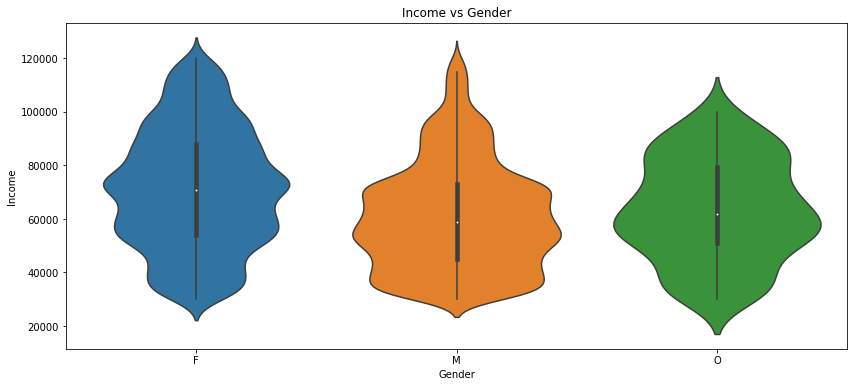

In [14]:
plt.figure(figsize=(14, 6))
sns.violinplot(x=profile[profile['gender'] != 'NA']['gender'], y=profile['income'])
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

In [15]:
# change the datetime format for became_member_on
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [16]:
# drop lines with income = nan and age == 118
new_df = profile.drop(profile[(profile["income"].isnull()) & (profile["age"] == 118)].index)

In [17]:
# One-hot encode Gender column
gender_dummies = pd.get_dummies(new_df["gender"])

In [18]:
# Specifying age range and one hot encoding
range_ages = pd.cut(x=new_df["age"], bins=[18, 20, 29, 39, 49, 59, 69, 79, 89, 99, 102])

In [19]:
# One-hot encode ages column
ages_dummies = pd.get_dummies(range_ages)

In [20]:
# Specifying income range and one hot encoding
   
range_income = pd.cut(x=new_df["income"], bins=[30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000,  120000])
income_dummies = pd.get_dummies(range_income)

In [21]:
# Concat
new_df = pd.concat([new_df, ages_dummies, income_dummies, gender_dummies], axis=1, sort=False)

In [22]:
# Dropping age,gender,income column
new_df = new_df.drop(["age", "gender", "income"], axis=1)

In [23]:
cleaned_profile = new_df

In [24]:
cleaned_profile

,became_member_on,id,"(18, 20]","(20, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 79]","(79, 89]",...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
1,2017-07-15,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,2018-04-26,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8,2018-02-09,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
13,2017-09-11,aa4862eba776480b8bb9c68455b8c2e1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
14,2014-02-13,e12aeaf2d47d42479ea1c4ac3d8286c6,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15,2016-02-11,31dda685af34476cad5bc968bdb01c53,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
16,2014-11-13,62cf5e10845442329191fc246e7bcea3,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
18,2017-12-31,6445de3b47274c759400cd68131d91b4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


cleaned_profile = clean_profile()
cleaned_profile.head()

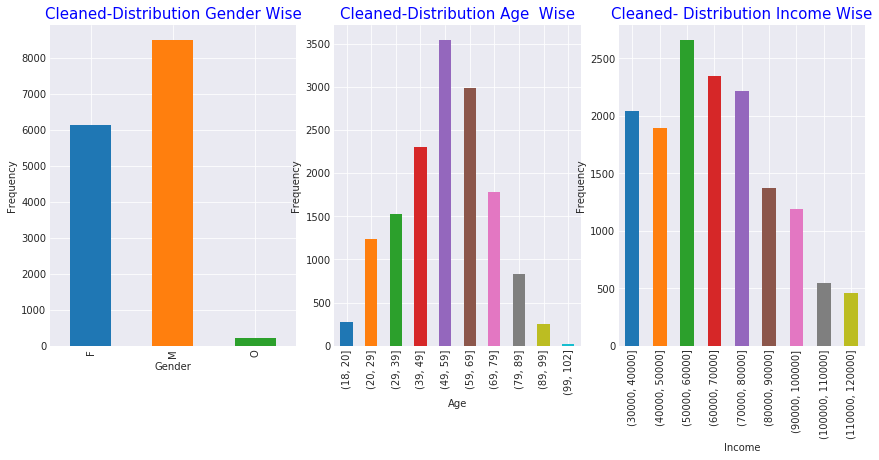

In [25]:
#Creating Subplots for distribution based on Gender,Age and Income for the Newly cleaned Profile data
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,3,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()
# GENDER BASED
cleaned_profile[cleaned_profile.columns[21:]].sum().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Cleaned-Distribution Gender Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Gender", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)


# AGE BASED
cleaned_profile[cleaned_profile.columns[2:12]].sum().plot.bar(ax=ax[1],fontsize=10) 
ax[1].set_title("Cleaned-Distribution Age  Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Age", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
cleaned_profile[cleaned_profile.columns[12:21]].sum().plot.bar(ax=ax[2],fontsize=10) 
ax[2].set_title("Cleaned- Distribution Income Wise", fontsize=15,color='blue')
ax[2].set_xlabel("Income", fontsize=10)
ax[2].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)
plt.show()

profile['membership_year'] = profile['became_member_on'].dt.year


.1 From profiles dataframe, which get more income: Males, Females, or Other?

### Data Cleaning Portfolio

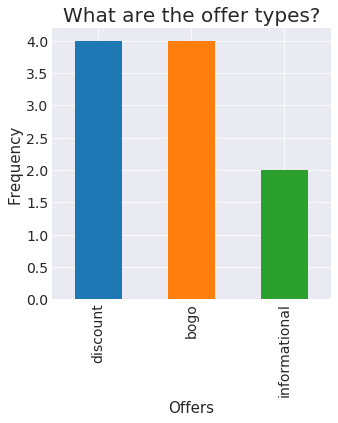

In [26]:
ax = portfolio["offer_type"].value_counts().plot.bar(
    figsize=(5,5),
    fontsize=14,

)

ax.set_title("What are the offer types?", fontsize=20)
ax.set_xlabel("Offers", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

In [27]:
check_nan(portfolio)

Total : 10


In [28]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [29]:
# One-hot encode channels column
channels = portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")

In [30]:
# One-hot encode offer_type column
offer_type = pd.get_dummies(portfolio['offer_type'])

In [31]:
def clean_portfolio(df=portfolio):
    """
    Takes the dataframe portfolio and cleans it by creating one-hot encodings.
    
    PARAMETERS:
        portfolio dataframe
        
    RETURNS:
        A new dataframe consisting of:
        - One-hot encoded channels column
        - One-hot encoded offer_type column   
        ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    """
   
    
    # Concat one-hot and df
    new_df = pd.concat([df, channels, offer_type], axis=1, sort=False)
    
    # Remove channels and offer_type
    new_df = new_df.drop(['channels', 'offer_type'], axis=1)
    
    # Organize columns
    columns = ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    new_df = new_df[columns]
    
    return new_df

In [32]:
cleaned_portfolio= clean_portfolio() 
cleaned_portfolio

,id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


### Data Cleaning Transript

In [33]:
check_nan(transcript)

Total : 306534


In [34]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [35]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [36]:
# Functions to create offer id and amount columns from the transcript table.
def create_offer_id_column(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_column(val):
    if list(val.keys())[0] in ["amount"]:
        return list(val.values())[0]

In [37]:
transcript['offer_id'] = transcript.value.apply(create_offer_id_column)
transcript['amount'] = transcript.value.apply(create_amount_column)

In [38]:
#  One-hot encode event column
event = pd.get_dummies(transcript['event'])

In [39]:
# Concat one-hot and df
new_df = pd.concat([transcript, event], axis=1, sort=False)

In [40]:
# Create and Drop Transaction
transaction = new_df[new_df["transaction"]==1]
new_df = new_df.drop(transaction.index)

In [41]:
# Drop
new_df = new_df.drop(columns = ["event","value", "amount", "transaction"])

In [42]:
cleaned_transcript = new_df
cleaned_transcript

,person,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


## Modeling Data

## Merdge The Data

In [43]:
# Rename column name id with offer_id
new_portfolio = cleaned_portfolio.rename(columns={"id": "offer_id" })

In [44]:
#  Merge cleaned portfolio and transcript
final_transcript = cleaned_transcript.merge(new_portfolio[new_portfolio.columns])

In [45]:
# Rename column id with person to merge with transcript
new_profile = cleaned_profile.rename(columns={"id": "person" })

In [46]:
# Merge profile with transcript on person column
final_transcript = final_transcript.merge(new_profile[new_profile.columns])

In [47]:
# Rename columns on final transcript.
columns_names = ['person', 'time', 'offer_id',  'offer completed', 'offer received',' offer viewed', 
 'difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational','became_member_on',
 "18-20", "20-29", "29-39", "39-49", "49-59", "59-69", "69-79", "79-89", "89-99", "99-102", "30-40K", "40-50K", "50-60K",
 "60-70K", "70-80K", "80-90K", "90-100K", "100-110K", "110-120K", 
 'F', 'M', 'O']

In [48]:
final_transcript.columns = columns_names

In [49]:
def re_org_col():
    # Reorganize columns
    cols_order = ['person', 'offer_id', 'time', 
          'difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
          'became_member_on',
          "18-20", "20-29", "29-39", "39-49", "49-59", "59-69", "69-79", "79-89", "89-99", "99-102", 'F', 'M', 'O',
          "30-40K", "40-50K", "50-60K", "60-70K", "70-80K", "80-90K", "90-100K", "100-110K", "110-120K", 
          'offer received',' offer viewed', 'offer completed'     
         ]     
    return final_transcript[cols_order]

In [50]:
final_transcript = re_org_col()
final_df=final_transcript

## Prep Data for Modelling 

In [51]:
final_df[final_df["offer completed"] == 1][["offer received", ' offer viewed', 'informational']].sum()


offer received    0
 offer viewed     0
informational     0
dtype: int64

In [52]:
# Since we are interested in offer completion , lets remove other attributes before going on to creaate a model
final_df = final_df.drop(["offer received", ' offer viewed', 'informational', "became_member_on"], axis=1)


In [53]:
final_df

,person,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,30-40K,40-50K,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,5,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,5,7,5,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,5,7,5,1,1,0,1,...,0,0,0,0,0,0,1,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,5,5,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,510,5,5,5,1,1,1,1,...,0,0,0,0,0,0,1,0,0,1
5,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,582,5,5,5,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
6,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,10,7,10,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
7,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,10,7,10,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
8,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,510,10,7,10,1,1,1,0,...,0,0,0,0,0,0,1,0,0,1
9,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,0,3,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [54]:
# Lets Split the data into feature and target label
target = final_df['offer completed']
features = final_df.drop('offer completed', axis = 1)
print(" Number of total features: {} ".format(len(features.columns)))

 Number of total features: 34 


In [55]:
features.head()

,person,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,O,30-40K,40-50K,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,5,5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,510,5,5,5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0


In [56]:
target.head()

0    0
1    0
2    1
3    0
4    1
Name: offer completed, dtype: uint8

### Normalize Numerical Features

In [57]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numericals = features.columns[2:6]

features_log_minmax_transform = pd.DataFrame(data = features)
features_log_minmax_transform[numericals] = scaler.fit_transform(features[numericals])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,person,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,O,30-40K,40-50K,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.000000,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.008403,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.184874,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0.705882,0.25,0.285714,0.5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0.714286,0.25,0.285714,0.5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0


In [58]:
features_final = features_log_minmax_transform[features_log_minmax_transform.columns[2:]]
features_final.head()

,time,difficulty,duration,reward,email,mobile,social,web,bogo,discount,...,O,30-40K,40-50K,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K
0,0.000000,0.25,0.571429,0.5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.008403,0.25,0.571429,0.5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.184874,0.25,0.571429,0.5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.705882,0.25,0.285714,0.5,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0.714286,0.25,0.285714,0.5,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [59]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    target, 
                                                    test_size = 0.20, 
                                                    random_state = 42,
                                                   stratify=target)

# Display result after splitting..
print("results of the split\n------")
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

print("\nclass distribution\n------")
print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))

results of the split
------
Training set has 119044 samples.
Testing set has 29761 samples.

class distribution
------
y_train class distribution
0    0.781971
1    0.218029
Name: offer completed, dtype: float64
y_test class distribution
0    0.781963
1    0.218037
Name: offer completed, dtype: float64


In [60]:
accuracy = accuracy_score(y_train,np.ones(len(y_train)))
fscore = fbeta_score(y_train,np.ones(len(y_train)), beta=0.5)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, fscore: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2180, fscore: 0.2584]


In [61]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    Takes a learning algorithm and uses it to train and predict the samples and returns the performance.
    
    PARAMETERS:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: label training set
       - X_test: features testing set
       - y_test: label testing set
    RETURNS
        Performance results for the learning algorithm.
    '''
    
    results = {}
    
    #  Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    #  Calculate the training time
    results['train_time'] = end - start
        
    #  Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    #  Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    #  Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #  Compute F-score on the the first 300 training samples using fbeta_score()
    #results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['f_train'] = f1_score(y_train[:300], predictions_train)
        
    # TODO: Compute F-score on the test set which is y_test
    #results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    results['f_test'] = f1_score(y_train[:300], predictions_train)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [62]:
def evaluate(results, accuracy, f1):
    """
    Uses performance of various learning algorithms to produce visualizations.
    
    PARAMETERS:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    RETURNS:
         NONE
    """
   
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#66FFB2','#CCCC00','#9B3510']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()

DecisionTreeClassifier trained on 1190 samples.
DecisionTreeClassifier trained on 11904 samples.
DecisionTreeClassifier trained on 119044 samples.
GaussianNB trained on 1190 samples.
GaussianNB trained on 11904 samples.
GaussianNB trained on 119044 samples.
RandomForestClassifier trained on 1190 samples.
RandomForestClassifier trained on 11904 samples.
RandomForestClassifier trained on 119044 samples.


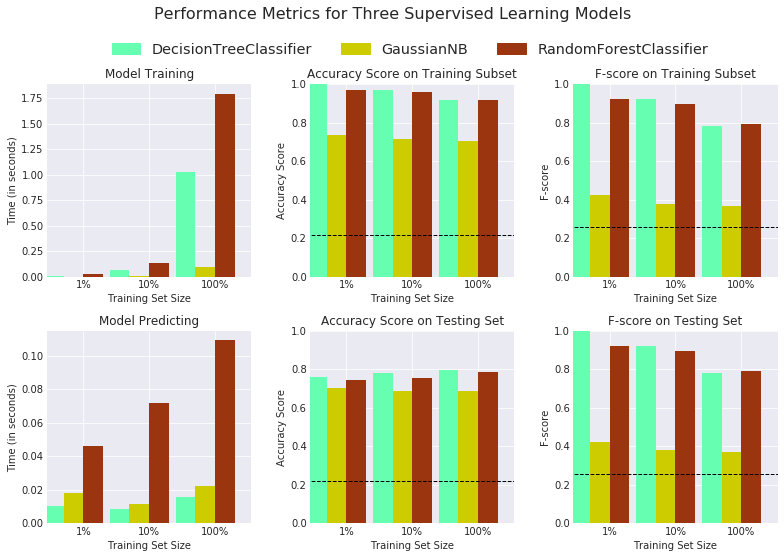

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


#  Initializing the three models
clf_A = DecisionTreeClassifier(random_state =42) #DecisionTree
clf_B = GaussianNB() #NainveBayes
# n_estimators=10 is a default parameter. Necessary for not error message. 
clf_C = RandomForestClassifier(random_state =42, n_estimators=10) #EnsembleMethods 

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 =  int(len(y_train))
samples_10 =  int((samples_100 * 10/100))
samples_1 =   int((samples_100 * 1)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

## Model Tuning 

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#  Initialize the classifier
clf = RandomForestClassifier(random_state =42, n_estimators=20)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'max_features':['auto', 'sqrt'], 'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]} 

#  Make an fbeta_score scoring object using make_scorer()
beta= 0.01
#scorer = make_scorer(fbeta_score, beta=beta)
scorer = make_scorer(precision_score)

#  Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, cv=3, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = beta)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = beta)))

In [ ]:
# Print a Confusion Matrix
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = conf_mtx = confusion_matrix(y_test, best_predictions).ravel()
con_mtx = np.array([[tp, fn],[fp, tn]])
con_mtx

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, support, nada = precision_recall_fscore_support(y_test, best_predictions, average='binary', pos_label=1)
print(f"The precision of model is {precision:0.4f}.")
print(f"The recall of model is {recall:0.4f}.")

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Provided a sklearn confusion matrix, visualizes the matrix.

    PARAMETERS
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Wistia')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(cm           = con_mtx, 
                      normalize    = False,
                      target_names = ['positive', 'negative'],
                      title        = "Confusion Matrix")

In [ ]:
best_clf

We can see that the Random Forest classifier performed the best among the three classifiers.

# Link to the Medium Blog
https://medium.com/@mrmoxam/project-overview-8c4b42190383